## set environment

In [2]:
pip install geopandas libpysal tobler pygeos watermark -q

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 2.4 MB 34.8 MB/s 
     |████████████████████████████████| 2.1 MB 20.6 MB/s 
     |████████████████████████████████| 16.7 MB 332 kB/s 
     |████████████████████████████████| 6.3 MB 7.8 MB/s 
     |████████████████████████████████| 19.3 MB 378 kB/s 
     |████████████████████████████████| 1.6 MB 36.6 MB/s 
     |████████████████████████████████| 130 kB 46.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from tobler.area_weighted import area_interpolate
from libpysal.weights import Queen

In [4]:
%reload_ext watermark
%watermark -iv -a 'Dan Levine' -u -d -v

Author: Dan Levine

Last updated: 2022-08-22

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

pandas   : 1.3.5
geopandas: 0.10.2
numpy    : 1.21.6



## read in data

In [ ]:
zip_geom = gpd.read_file('raw data/ZIPs.zip')

In [ ]:
tracts_geom = gpd.read_file('raw data/tracts_clipped.zip')

In [ ]:
tracts_geom['GEOID'] = pd.to_numeric(tracts_geom['GEOID'])

In [ ]:
broadband_now_data = pd.read_csv('raw data/broadband_now.csv', encoding = "ISO-8859-1")

In [ ]:
microsoft_data = pd.read_csv('raw data/microsoft_broadband_usage_zip.csv')

In [ ]:
microsoft_data = microsoft_data.drop_duplicates(subset='POSTAL CODE')

In [ ]:
microsoft_data

,ST,COUNTY NAME,COUNTY ID,POSTAL CODE,BROADBAND USAGE,ERROR RANGE (MAE)(+/-),ERROR RANGE (95%)(+/-),MSD
0,SC,Abbeville,45001,29639,0.948,0.034,0.110,0.002
1,SC,Abbeville,45001,29620,0.398,0.002,0.007,0.000
2,SC,Abbeville,45001,29659,0.206,0.152,0.608,0.043
3,SC,Abbeville,45001,29638,0.369,0.010,0.031,-0.001
4,SC,Abbeville,45001,29628,0.221,0.014,0.043,0.000
...,...,...,...,...,...,...,...,...
32730,TX,Zavala,48507,78839,0.514,0.006,0.018,-0.001
32731,TX,Zavala,48507,78872,0.071,0.020,0.061,0.000
32732,SD,Ziebach,46137,57622,0.000,0.110,0.406,0.031
32733,SD,Ziebach,46137,57748,0.000,0.065,0.228,0.013


## merge ZIP-level data

In [ ]:
zip_geom = zip_geom.rename(columns={'GEOID10':'ZIP'})

In [ ]:
zip_geom['ZIP'] = zip_geom['ZIP'].astype(int)

In [ ]:
zip_geom['ZIP'].duplicated().any()

False

In [ ]:
zip_data = zip_geom.merge(broadband_now_data, left_on='ZIP', right_on='Zip', how='left', validate='1:1')

In [ ]:
zip_data = zip_data.merge(microsoft_data, left_on='ZIP', right_on='POSTAL CODE', how='left', validate='1:1')

In [ ]:
zip_data = zip_data.drop(['Zip', 'POSTAL CODE'], axis=1)

In [ ]:
zip_data.columns

Index(['ZCTA5CE10', 'ZIP', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'Population',
       'County', 'State', 'WiredCount_2020', 'Fwcount_2020',
       'AllProviderCount_2020', 'Wired25_3_2020', 'Wired100_3_2020',
       'All25_3_2020', 'All100_3', 'TestCount', 'AverageMbps',
       'FastestAverageMbps', '%Access to Terrestrial Broadband',
       'Lowest Priced Terrestrial Broadband Plan', 'WiredCount_2015',
       'Fwcount_2015', 'AllProviderCount_2015', 'Wired25_3_2015',
       'Wired100_3_2015', 'All25_3_2015', 'All100_3.1', 'ST', 'COUNTY NAME',
       'COUNTY ID', 'BROADBAND USAGE', 'ERROR RANGE (MAE)(+/-)',
       'ERROR RANGE (95%)(+/-)', 'MSD'],
      dtype='object')

In [ ]:
zip_data.isna().any()

ZCTA5CE10                                   False
ZIP                                         False
CLASSFP10                                   False
MTFCC10                                     False
FUNCSTAT10                                  False
ALAND10                                     False
AWATER10                                    False
INTPTLAT10                                  False
INTPTLON10                                  False
geometry                                    False
Population                                   True
County                                       True
State                                        True
WiredCount_2020                              True
Fwcount_2020                                 True
AllProviderCount_2020                        True
Wired25_3_2020                               True
Wired100_3_2020                              True
All25_3_2020                                 True
All100_3                                     True


#### check and fill NaN

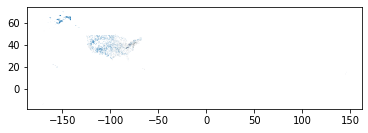

In [ ]:
zip_data[(zip_data['AverageMbps'].isna())| (zip_data['FastestAverageMbps'].isna())].plot()

filling based on neighbors became intractable. 
NaN values are where there are fewer tests. Assume this means they are on the lower side of speed also. so fill with first quartile speed. (This is a somewhat arbitrary assumption. It affects 11% of rows but will be somewhat smoothed by the spatial resampling/interpolation)



In [ ]:
zip_data['AverageMbps'].describe()

count    26368.000000
mean        54.349508
std         50.247723
min          0.000000
25%         14.160000
50%         43.910000
75%         82.552500
max       2289.330000
Name: AverageMbps, dtype: float64

In [ ]:
zip_data['FastestAverageMbps'].describe()

count    26368.000000
mean       134.514536
std        128.442304
min          0.000000
25%         30.650000
50%        102.750000
75%        216.857500
max       6802.470000
Name: FastestAverageMbps, dtype: float64

In [ ]:
average_speed_first_quartile = zip_data['AverageMbps'].quantile(0.25)

In [ ]:
average_fastest_speed_first_quartile = zip_data['FastestAverageMbps'].quantile(0.25)

In [ ]:
zip_data['AverageMbps'] = zip_data['AverageMbps'].fillna(average_speed_first_quartile)

In [ ]:
zip_data['FastestAverageMbps'] = zip_data['FastestAverageMbps'].fillna(average_fastest_speed_first_quartile)

## spatial interpolation

#### reproject

In [ ]:
# Equal Earth Americas
projection = 'EPSG:8858'

In [ ]:
zip_data = zip_data.to_crs(projection)
tracts_geom = tracts_geom.to_crs(projection)

#### interpolate

In [ ]:
%%time

data_interpolated = area_interpolate(
    source_df=zip_data,
    target_df=tracts_geom,
    intensive_variables=[
      'BROADBAND USAGE',
      'WiredCount_2020',
      'Wired25_3_2020',
      'Wired100_3_2020',
      'AverageMbps',
      'FastestAverageMbps',   
      ],
    extensive_variables=[
       'TestCount' 
    ],
    n_jobs=-1
)

/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: TestCount, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: BROADBAND USAGE, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: WiredCount_2020, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: Wired25_3_2020, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: Wired100_3_2020, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


CPU times: user 23 s, sys: 1.89 s, total: 24.9 s
Wall time: 1min 21s


In [ ]:
data_interpolated

,TestCount,BROADBAND USAGE,WiredCount_2020,Wired25_3_2020,Wired100_3_2020,AverageMbps,FastestAverageMbps,geometry
0,2189.380919,1.000000,4.000000,2.000000,2.000000,99.520000,234.930000,"POLYGON ((1282181.401 4924645.993, 1282408.907..."
1,64.260787,0.327040,3.000314,3.000314,3.000314,33.191817,105.690772,"POLYGON ((715937.267 5038730.329, 715924.414 5..."
2,584.342512,0.864404,6.000000,4.979500,3.989750,119.719226,281.941103,"POLYGON ((1344868.004 5086556.451, 1344871.665..."
3,882.561159,0.421460,5.000839,5.000839,5.000839,91.383568,236.867713,"POLYGON ((-2781492.770 4688702.493, -2781377.0..."
4,7103.061717,0.926883,9.997749,8.998523,7.999297,142.144526,371.430960,"POLYGON ((-598414.903 4112968.767, -598399.117..."
...,...,...,...,...,...,...,...,...
73863,1407.698674,0.496744,7.683893,4.873377,4.873377,64.672147,181.668107,"POLYGON ((-384240.520 3750014.621, -382283.717..."
73864,967.905346,0.194160,4.999610,4.999610,4.999610,85.217296,235.726194,"POLYGON ((250118.223 4176977.637, 250211.224 4..."
73865,900.233275,0.000000,2.227884,2.227884,1.113931,20.830893,55.188890,"POLYGON ((2190981.310 2298516.917, 2191025.103..."
73866,3263.507805,1.000000,5.003539,5.003539,5.003539,110.467788,291.475775,"POLYGON ((-2783672.849 4644481.968, -2783424.6..."


In [ ]:
data_interpolated = data_interpolated.drop(columns=['geometry'])

In [ ]:
data_interpolated = data_interpolated.add_prefix('area_weighted_')

In [ ]:
data_interpolated['GEOID'] = tracts_geom['GEOID'].astype(int)

In [ ]:
data_interpolated.to_csv('processed data/coverage_and_usage__area_weighted.csv')

### in batches dropping the NaN rows from each source dataset

In [ ]:
zip_data_providers = zip_data.dropna(subset=[
    'WiredCount_2020',
    'Wired25_3_2020',
    'Wired100_3_2020']
)

In [ ]:
%%time

providers_data_interpolated = area_interpolate(
    source_df=zip_data_providers,
    target_df=tracts_geom,
    intensive_variables=[
      'WiredCount_2020',
      'Wired25_3_2020',
      'Wired100_3_2020' 
      ],
    n_jobs=-1
).drop(columns='geometry')

CPU times: user 19.5 s, sys: 1.55 s, total: 21 s
Wall time: 1min 14s


In [ ]:
zip_data_usage = zip_data.dropna(subset=['BROADBAND USAGE'])

In [ ]:
%%time

usage_data_interpolated = area_interpolate(
    source_df=zip_data_usage,
    target_df=tracts_geom,
    intensive_variables=[
      'BROADBAND USAGE' 
      ],
    n_jobs=-1
).drop(columns='geometry')

CPU times: user 20.8 s, sys: 2.13 s, total: 23 s
Wall time: 1min 18s


In [ ]:
zip_data_mlab_speed = zip_data.dropna(subset=[
      'AverageMbps',
      'FastestAverageMbps'
      ]
)

In [ ]:
%%time

mlab_speed_data_interpolated = area_interpolate(
    source_df=zip_data_mlab_speed,
    target_df=tracts_geom,
    intensive_variables=[
      'AverageMbps',
      'FastestAverageMbps',   
      ],
    n_jobs=-1
).drop(columns='geometry').add_prefix('mlab_')

CPU times: user 21.4 s, sys: 2.44 s, total: 23.8 s
Wall time: 1min 17s


In [ ]:
mlab_test_count_data_interpolated = area_interpolate(
    source_df=zip_data,
    target_df=tracts_geom,
    extensive_variables=[
       'TestCount' 
      ],
    n_jobs=-1
).drop(columns='geometry').add_prefix('mlab_')

/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: TestCount, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


In [ ]:
data_interpolated = pd.concat([
        providers_data_interpolated,
        usage_data_interpolated,
        mlab_speed_data_interpolated,
        mlab_test_count_data_interpolated
    ], axis=1
    ).add_prefix(
        'area_weighted_'
      ).join(
        tracts_geom['GEOID']
    )

In [ ]:
data_interpolated

,area_weighted_WiredCount_2020,area_weighted_Wired25_3_2020,area_weighted_Wired100_3_2020,area_weighted_BROADBAND USAGE,area_weighted_mlab_AverageMbps,area_weighted_mlab_FastestAverageMbps,area_weighted_mlab_TestCount,GEOID
0,4.000000,2.000000,2.000000,1.000000,99.520000,234.930000,2189.380919,34005702808
1,3.000314,3.000314,3.000314,0.327040,33.191817,105.690772,64.260787,39153504200
2,6.000000,4.979500,3.989750,0.864404,119.719226,281.941103,584.342512,36071000502
3,5.000839,5.000839,5.000839,0.421460,91.383568,236.867713,882.561159,6013370000
4,9.997749,8.998523,7.999297,0.926883,142.144526,371.430960,7103.061717,48113019204
...,...,...,...,...,...,...,...,...
73863,7.683893,4.873377,4.873377,0.496744,64.672147,181.668107,1407.698674,48245011303
73864,4.999610,4.999610,4.999610,0.194160,85.217296,235.726194,967.905346,1073012302
73865,2.227884,2.227884,1.113931,0.000000,20.830893,55.188890,900.233275,72113072400
73866,5.003539,5.003539,5.003539,1.000000,110.467788,291.475775,3263.507805,6081608023


In [ ]:
data_interpolated.to_csv('processed data/coverage_usage_mlab_speed__area_weighted.csv')